In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
"""
Part One, Camera Calibration & Undistortion
"""

'\nPart One, Camera Calibration & Undistortion\n'

In [3]:
def display(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [4]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

image_shape = cv2.imread(images[0]).shape

# Step through the list and search for chessboard corners

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[::-1][1:3], None, None)

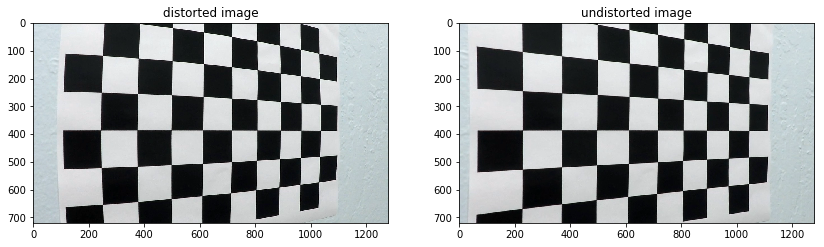

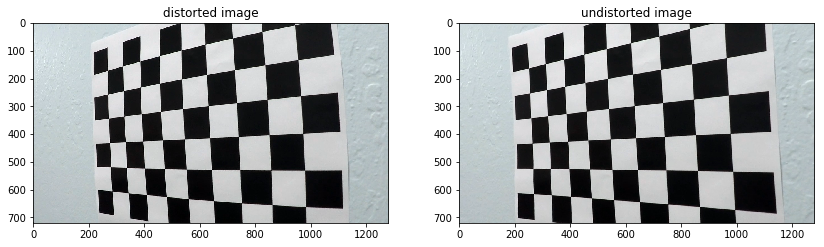

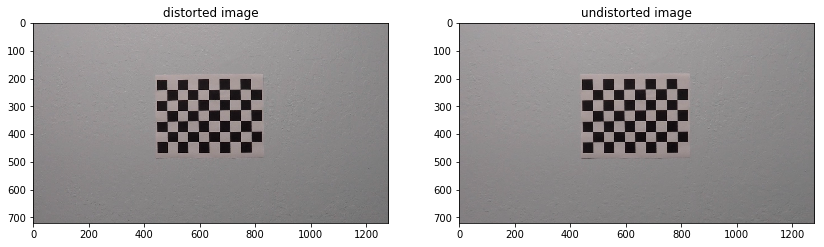

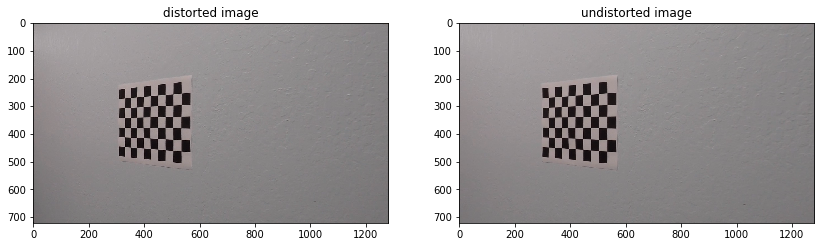

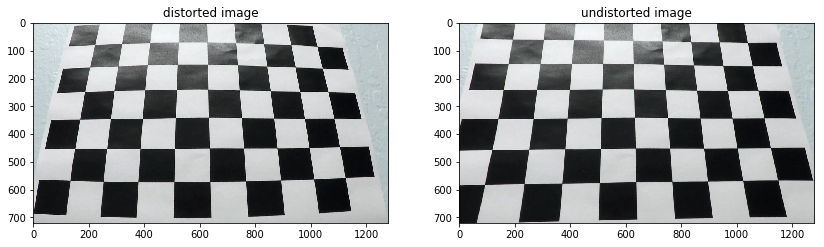

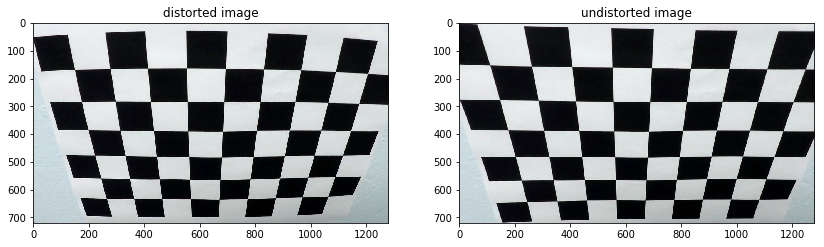

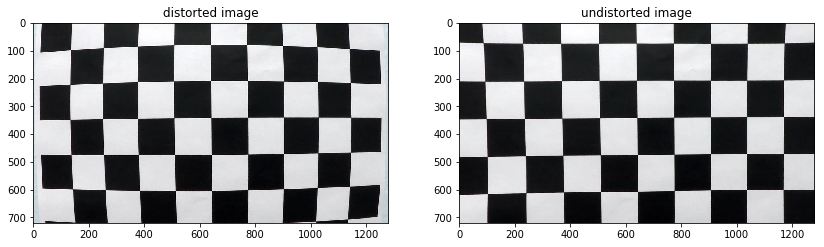

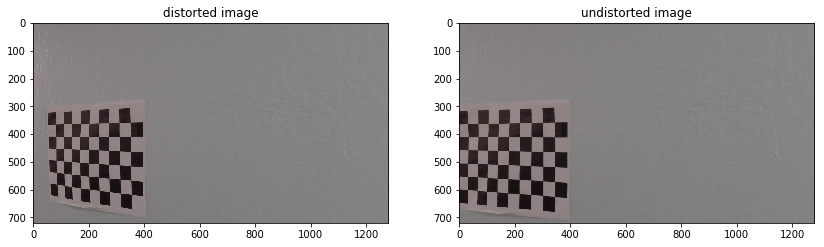

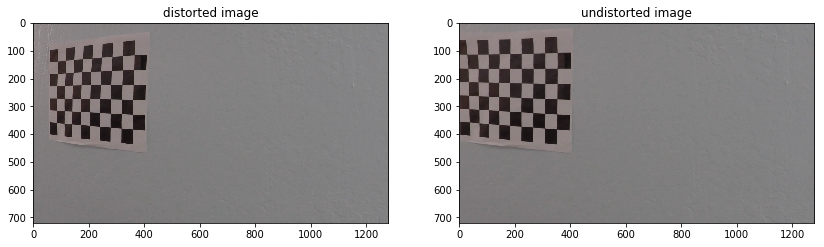

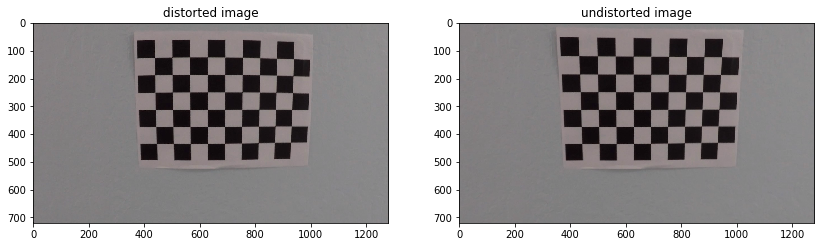

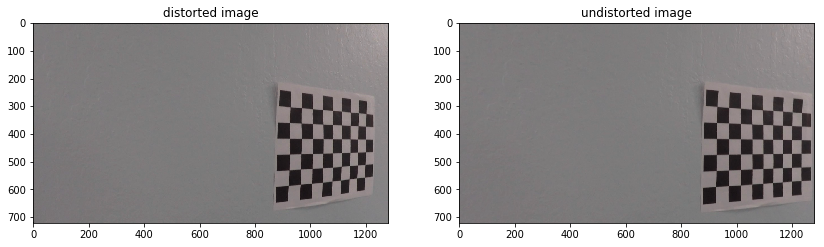

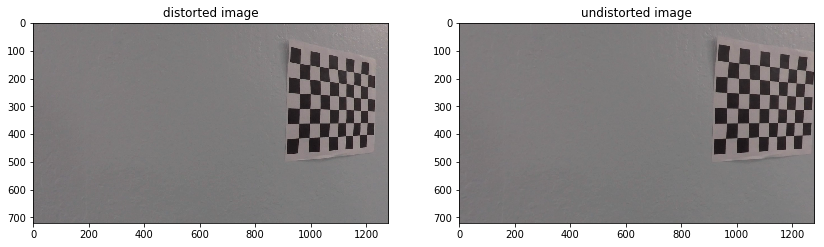

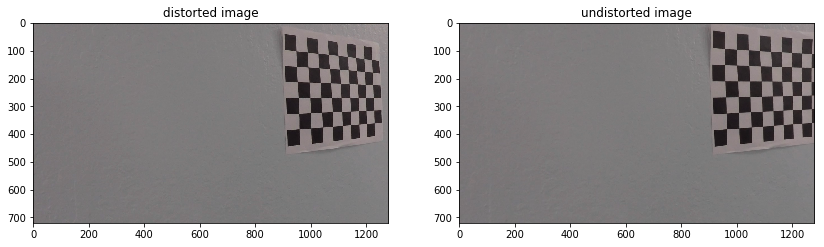

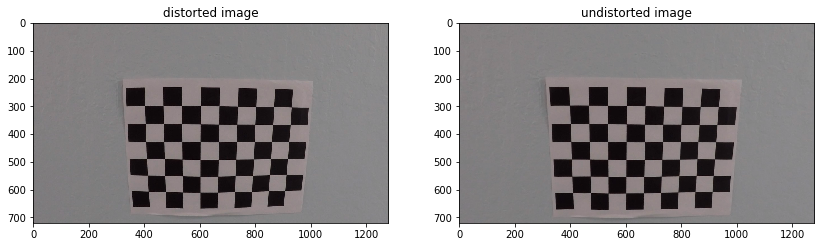

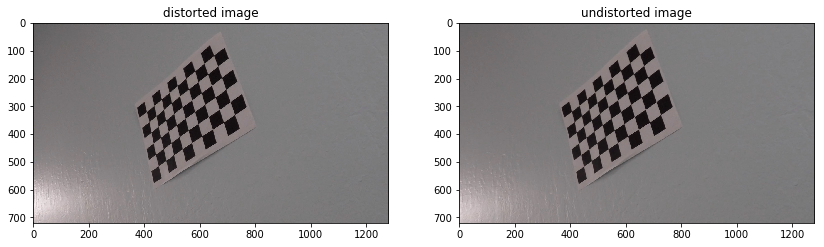

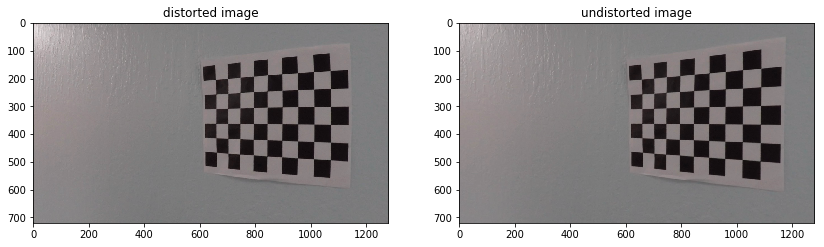

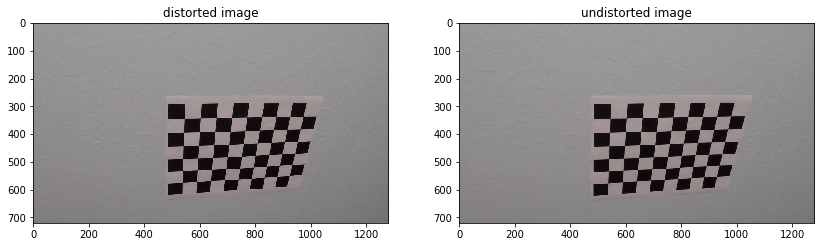

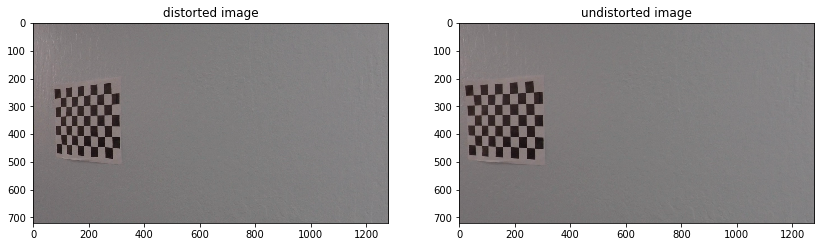

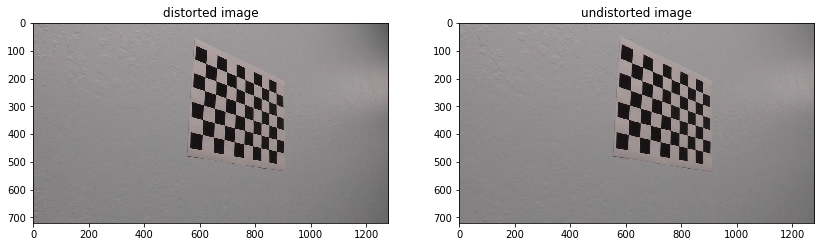

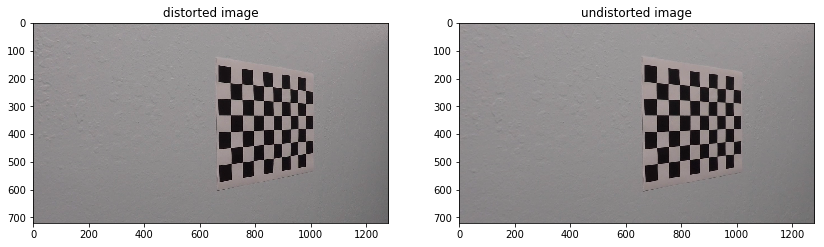

In [58]:
for fname in images:
    img = cv2.imread(fname)
    h, w, _ = img.shape
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    f,ax = plt.subplots(1,2, figsize=(14, 12))
    ax[0].imshow(img)
    ax[0].set_title('distorted image')
    ax[1].imshow(dst)
    ax[1].set_title('undistorted image')
    plt.show()

plt.close()

In [6]:
"""
Part Two: Color Space & Gradient
"""

'\nPart Two: Color Space & Gradient\n'

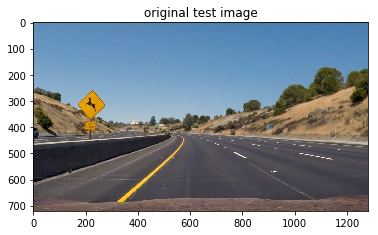

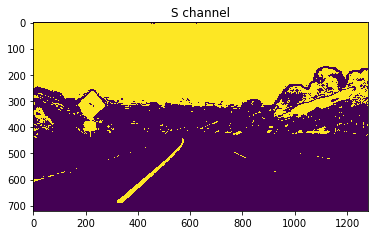

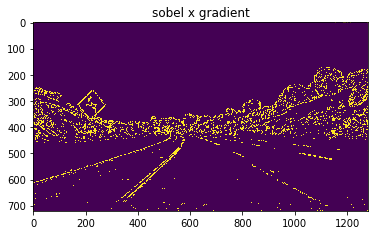

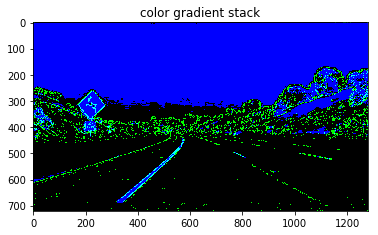

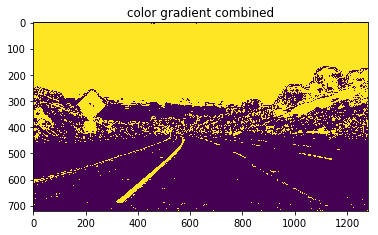

In [7]:
S_CHANNEL_THRESH = (90, 255)

def get_S_channel_binary_mask(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    LOWER_B, UPPER_B = S_CHANNEL_THRESH
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S >= LOWER_B) & (S <= UPPER_B)] = 1
    return binary

GRADIENT_THRESH = (20, 100)

def get_gradient_binary_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    LOWER_B, UPPER_B = GRADIENT_THRESH
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    sobel_x_binary = np.zeros_like(scaled_sobel)
    sobel_x_binary[(scaled_sobel >= LOWER_B) & (scaled_sobel <= UPPER_B)] = 1
    return sobel_x_binary

def get_color_gradient_stack_binary_mask(image):
    s_binary = get_S_channel_binary_mask(image)
    sx_binary = get_gradient_binary_mask(image)
    return np.dstack((np.zeros_like(s_binary), sx_binary, s_binary)) * 255

def get_color_gradient_combined_binary_mask(image):
    s_binary = get_S_channel_binary_mask(image)
    sx_binary = get_gradient_binary_mask(image)
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    return combined_binary * 255
    
    
# Manual test the result of using S channel only.
test_img = mpimg.imread('test_images/test2.jpg')
s_binary = get_S_channel_binary_mask(test_img)
sx_binary = get_gradient_binary_mask(test_img)
stack_binary = get_color_gradient_stack_binary_mask(test_img)
combined_binary = get_color_gradient_combined_binary_mask(test_img)

display(test_img, 'original test image')
display(s_binary, 'S channel')
display(sx_binary, 'sobel x gradient')
display(stack_binary, 'color gradient stack')
display(combined_binary, 'color gradient combined')

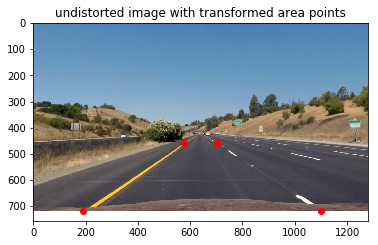

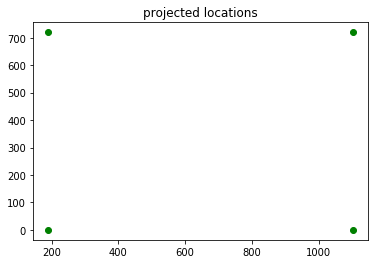

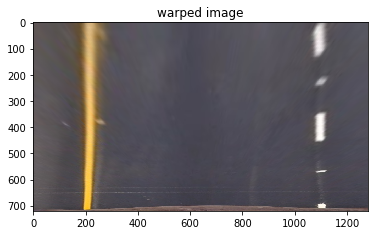

In [8]:
"""
Part Three: Perspective Transform
I will be using "test_images/straight_lines1.jpg" as an example.
"""
SRC_A, SRC_B, SRC_C, SRC_D = (190, 720), (1102, 720), (578, 460), (702, 460)
DST_A, DST_B, DST_C, DST_D = (190, 720), (1102, 720), (190, 0), (1102, 0)

straight_img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted_straight_img = cv2.undistort(straight_img, mtx, dist, None, mtx)


plt.imshow(undistorted_straight_img)
plt.imsave('output_images/undistorted_straight_lines1.jpg', undistorted_straight_img)


plt.plot(SRC_A[0], SRC_A[1], 'ro')
plt.plot(SRC_B[0], SRC_B[1], 'ro')
plt.plot(SRC_C[0], SRC_C[1], 'ro')
plt.plot(SRC_D[0], SRC_D[1], 'ro')
plt.title('undistorted image with transformed area points')
plt.show()

# Plot warped locations.
plt.plot(DST_A[0], DST_A[1], 'go')
plt.plot(DST_B[0], DST_B[1], 'go')
plt.plot(DST_C[0], DST_C[1], 'go')
plt.plot(DST_D[0], DST_D[1], 'go')
plt.title('projected locations')
plt.show()

SRC_PTS = np.float32([SRC_A, SRC_B, SRC_C, SRC_D])
DST_PTS = np.float32([DST_A, DST_B, DST_C, DST_D])

M = cv2.getPerspectiveTransform(SRC_PTS, DST_PTS)
M_reverse = cv2.getPerspectiveTransform(DST_PTS, SRC_PTS)

h, w, _ = undistorted_straight_img.shape

warped = cv2.warpPerspective(undistorted_straight_img, M, (w, h), flags=cv2.INTER_LINEAR)
display(warped, 'warped image')

plt.show()

In [9]:
"""
Part Four: Lane Pixels Finding & Polynomial Fitting
I will be using the sliding window approach to find all the pixels
on the lane as well as the fitting polynomial.
"""

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [22]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))    
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Group all boundary points to make it a polygon.
    left_fit_pts = np.dstack((left_fitx, ploty))[0]
    right_fit_pts = np.flip(np.dstack((right_fitx, ploty))[0], axis=0)
    convex_polygon_pts = np.int32(np.concatenate((left_fit_pts, right_fit_pts), axis=0))
        
    cv2.fillConvexPoly(out_img, convex_polygon_pts, (0, 255, 0))

    # Vehicle is at the bottom of the image, so its position is the
    # largest y cordinate.
    vehicle_y = np.max(ploty)
    
    return out_img, left_fit, right_fit, vehicle_y

<function matplotlib.pyplot.show(*args, **kw)>

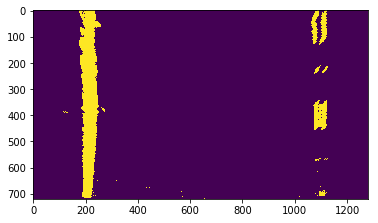

In [23]:
binary_warped = get_color_gradient_combined_binary_mask(warped)
plt.imshow(binary_warped)
plt.show

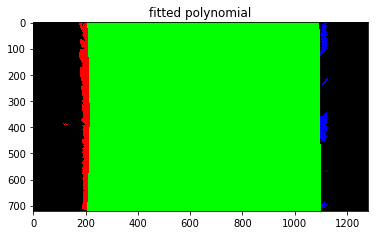

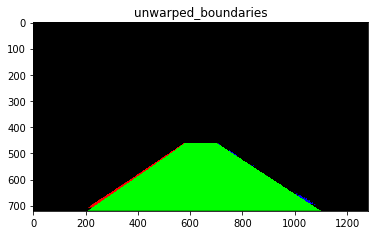

In [24]:
output, left_fit, right_fit, vehicle_y  = fit_polynomial(binary_warped)
display(output, 'fitted polynomial')
unwarped_output = cv2.warpPerspective(output, M_reverse, (w, h), flags=cv2.INTER_LINEAR)
display(unwarped_output, 'unwarped_boundaries')

In [66]:
"""
Part Five: compute lane curvature radius in meters.
"""

def get_current_curvature_radius(left_fit, right_fit, vehicle_y):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
        
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*vehicle_y*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*vehicle_y*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

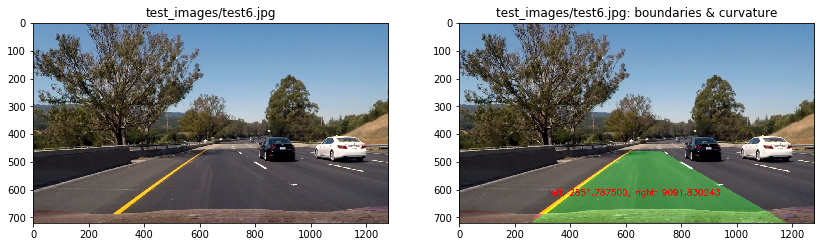

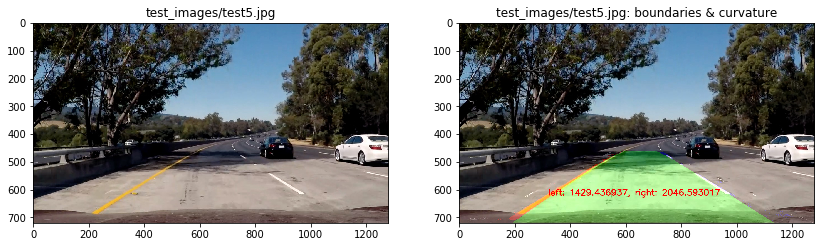

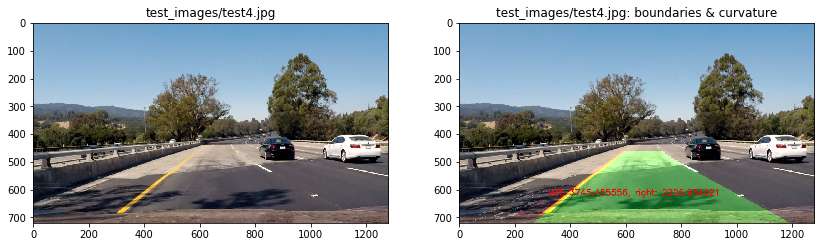

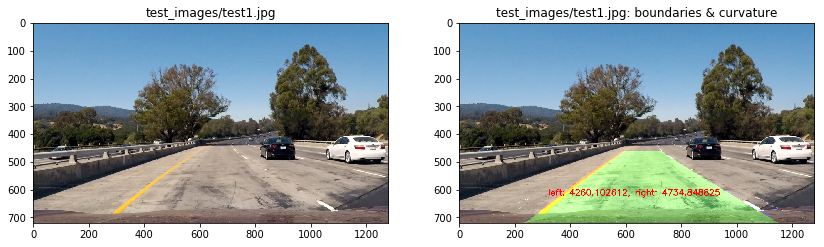

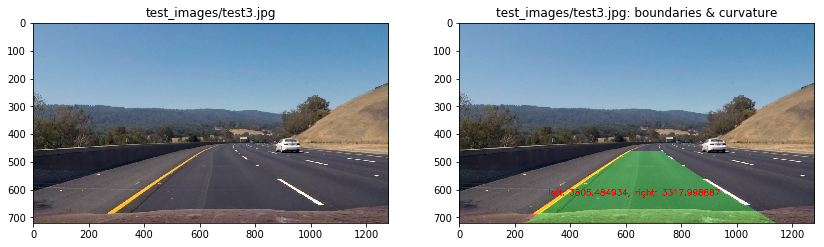

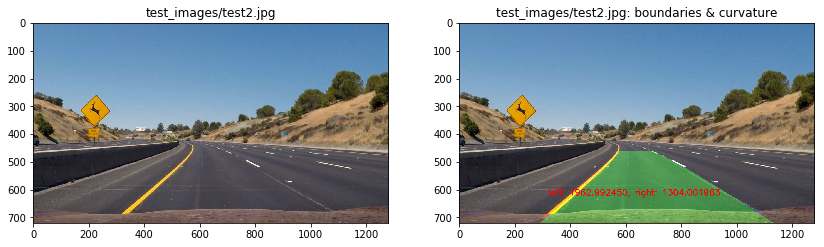

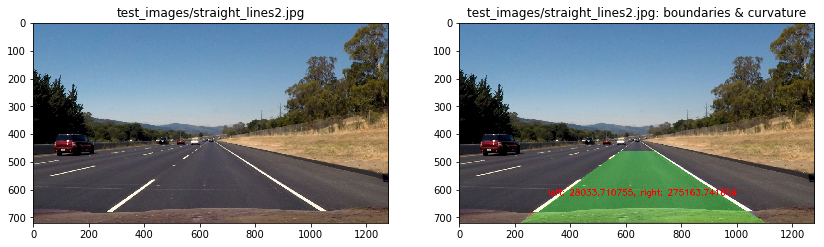

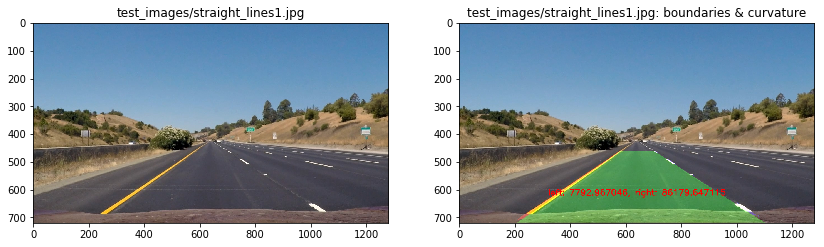

In [67]:
"""
Part Six: combine all steps to get lane boundaries.
"""
def process(img):
    # Using camera matrix and distortion matrix to
    # undistort image.
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Apply perspective transformation and generate
    # warped image.
    h, w, _ = img.shape
    warped = cv2.warpPerspective(undistorted_img, M, (w, h), flags=cv2.INTER_LINEAR)

    # Apply color & gradient technique to get binary mask.
    warped_binary_mask = get_color_gradient_combined_binary_mask(warped)
    
    # Using sliding window and polynomial fitting technique to get 
    # lane boundaries.
    warped_boundary_mask, left_fit, right_fit, vehicle_y = fit_polynomial(warped_binary_mask)
    unwarped_boundary_mask = cv2.warpPerspective(warped_boundary_mask, M_reverse, (w, h), flags=cv2.INTER_LINEAR)
    
    # Compute curvature
    left_cr, right_cr = get_current_curvature_radius(left_fit, right_fit, vehicle_y)
    
    # Combine.
    result = cv2.addWeighted(img, 1, unwarped_boundary_mask, 0.3, 0)
    curvature_text = 'left: %f, right: %f' % (left_cr, right_cr)
    cv2.putText(result, curvature_text, (w//4, h-100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv2.LINE_AA)

    return result

test_images = glob.glob('test_images/*.jpg')
for test_img in test_images:
    img = mpimg.imread(test_img)
    h, w, _ = img.shape
    processed = process(img)
    f,ax = plt.subplots(1,2, figsize=(14, 12))
    ax[0].imshow(img)
    ax[0].set_title(test_img)
    ax[1].imshow(processed)
    ax[1].set_title('%s: boundaries & curvature' % test_img)
    plt.show()

In [68]:
"""
Part Six: process video
"""
# To fix import errors.
import imageio
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

challenge_video_output = 'test_videos_output/challenge_video_output.mp4'
challenge_clip = VideoFileClip('test_videos/challenge_video.mp4')
challenge_clip_processed = challenge_clip.fl_image(process)
%time challenge_clip_processed.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video_output.mp4
[MoviePy] Writing video test_videos_output/challenge_video_output.mp4


100%|██████████| 485/485 [00:58<00:00,  8.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video_output.mp4 

CPU times: user 3min 43s, sys: 18 s, total: 4min 1s
Wall time: 59.1 s


In [69]:
harder_challenge_video_output = 'test_videos_output/harder_challenge_video_output.mp4'
harder_challenge_clip = VideoFileClip('test_videos/harder_challenge_video.mp4')
harder_challenge_clip_processed = harder_challenge_clip.fl_image(process)
%time harder_challenge_clip_processed.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video_output.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:07<00:00,  6.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video_output.mp4 

CPU times: user 11min 9s, sys: 1min 1s, total: 12min 11s
Wall time: 3min 9s
